In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from scipy.stats import reciprocal, uniform

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import warnings 
warnings.filterwarnings("ignore")


## Initial data

In [4]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [5]:
print('Dimension train_df:', train_df.shape)
print('Dimension test_df:', test_df.shape)

Dimension train_df: (891, 12)
Dimension test_df: (418, 11)


In [6]:
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [7]:
test_df.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


## Data description

In [8]:
train_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Data cleaning

In [10]:
train_df['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [11]:
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
train_df['Embarked'].fillna('S', inplace=True)

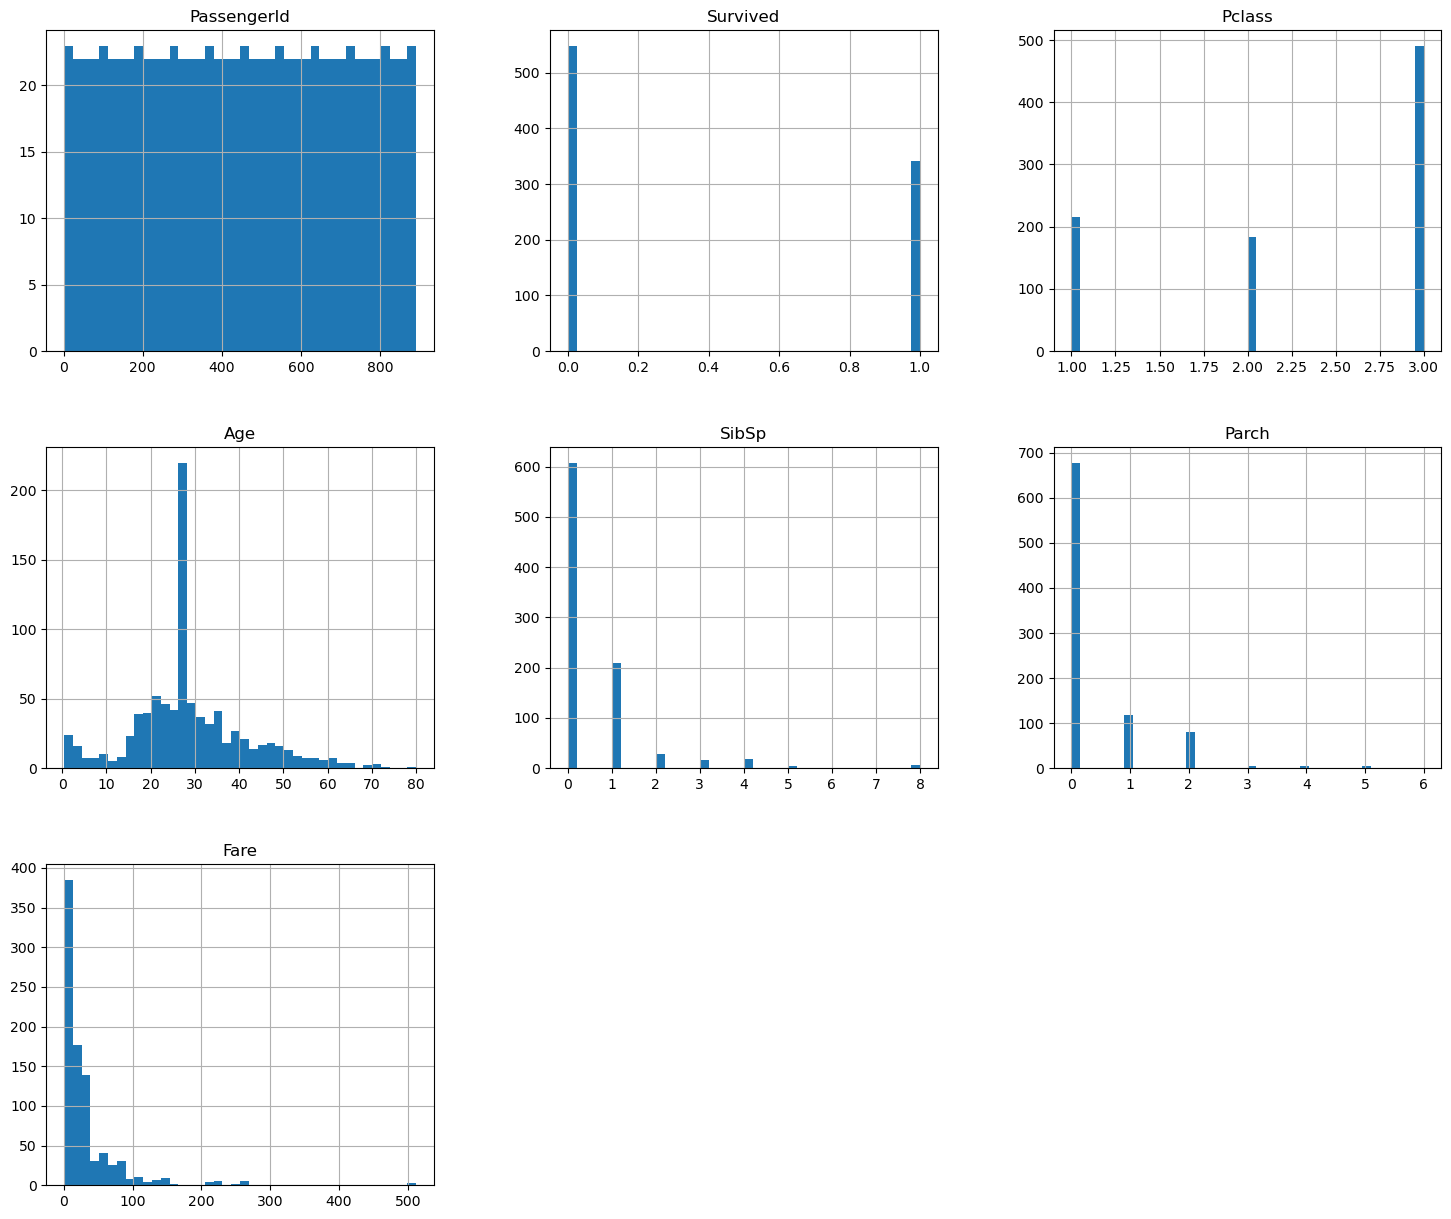

In [12]:
train_df.hist(bins=40, figsize=(18, 15))
plt.show()

## Data analysis

### Correlation matrix between numerical values and "Survived"

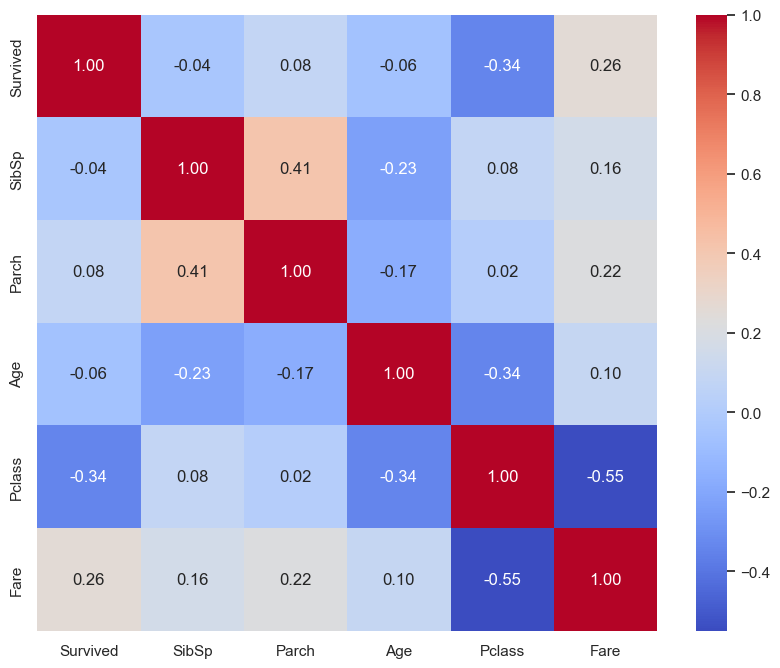

In [13]:
sns.set(rc={'figure.figsize':(10, 8)})

sns.heatmap(train_df[['Survived', 'SibSp', 'Parch', 'Age', 'Pclass', 'Fare']].corr(),
            annot=True,
            fmt='.2f',
            cmap='coolwarm')
plt.show()

### SibSp vs. Survived

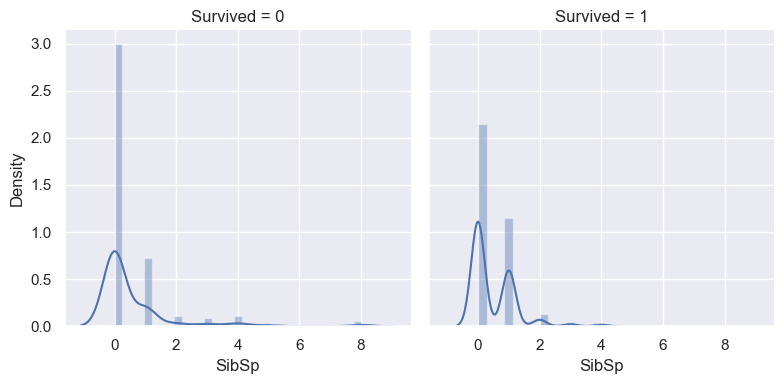

In [14]:
sibsp_survived_plt = sns.FacetGrid(train_df, col='Survived', height=4, aspect=1)
sibsp_survived_plt.map(sns.distplot, 'SibSp')

plt.show()

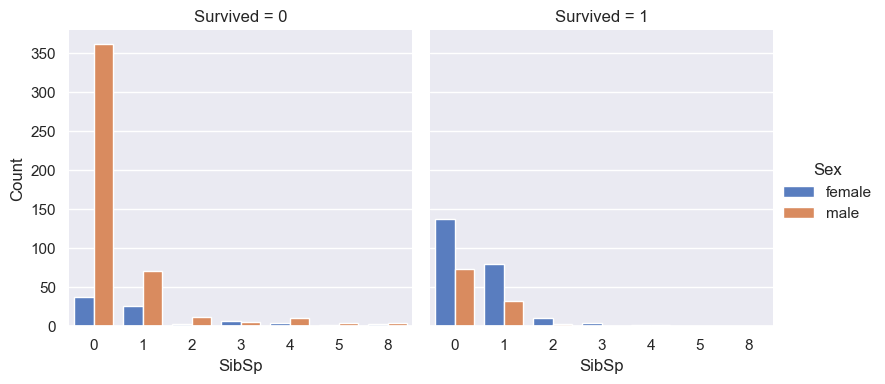

In [15]:
sibsp_sex_survived_plt = sns.catplot(x='SibSp',
                                        col='Survived',
                                        data=train_df,
                                        hue='Sex',
                                        kind='count',
                                        palette='muted',
                                        height=4,
                                        aspect=1)
sibsp_sex_survived_plt.despine(left=True)
sibsp_sex_survived_plt.set_ylabels('Count')

plt.show()

### Parch vs. Survived

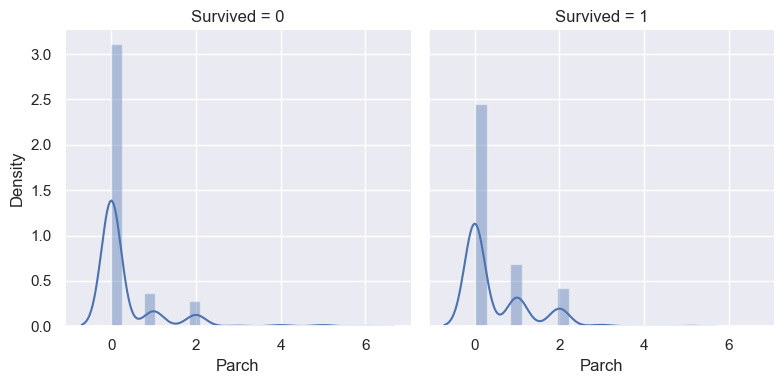

In [16]:
parch_survived_plt = sns.FacetGrid(train_df, col='Survived', height=4, aspect=1)
parch_survived_plt.map(sns.distplot, 'Parch')

plt.show()

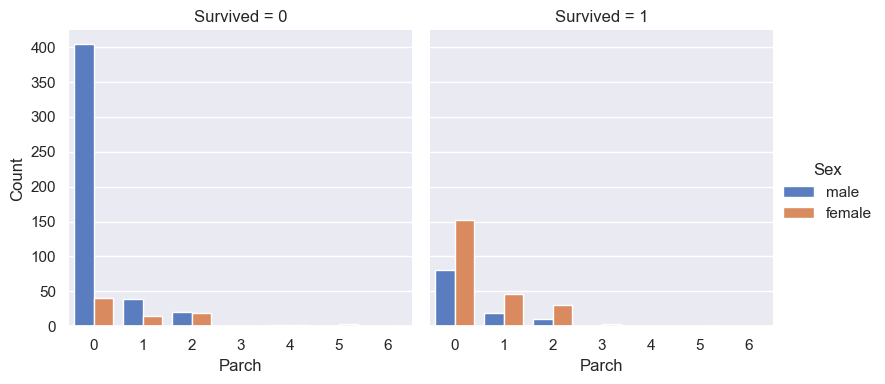

In [17]:
parch_sex_survived_plt = sns.catplot(x='Parch',
                                        col='Survived',
                                        data=train_df,
                                        hue='Sex',
                                        kind='count',
                                        palette='muted',
                                        height=4,
                                        aspect=1)
parch_sex_survived_plt.despine(left=True)
parch_sex_survived_plt.set_ylabels('Count')

plt.show()

### Age vs. Survived

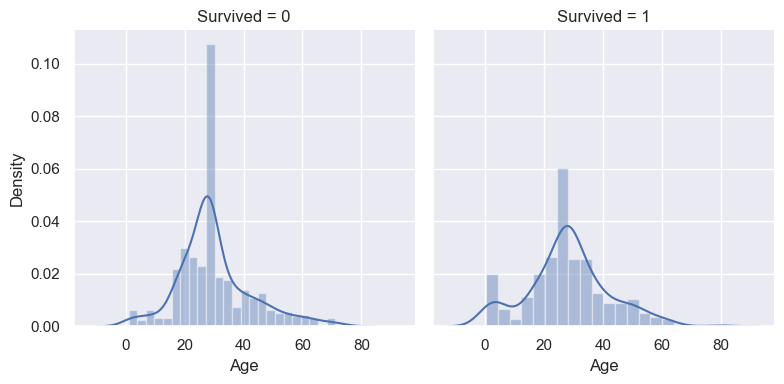

In [18]:
age_survived_plt = sns.FacetGrid(train_df, col='Survived', height=4, aspect=1)
age_survived_plt.map(sns.distplot, 'Age')

plt.show()

### Age vs. Sex vs. Survived

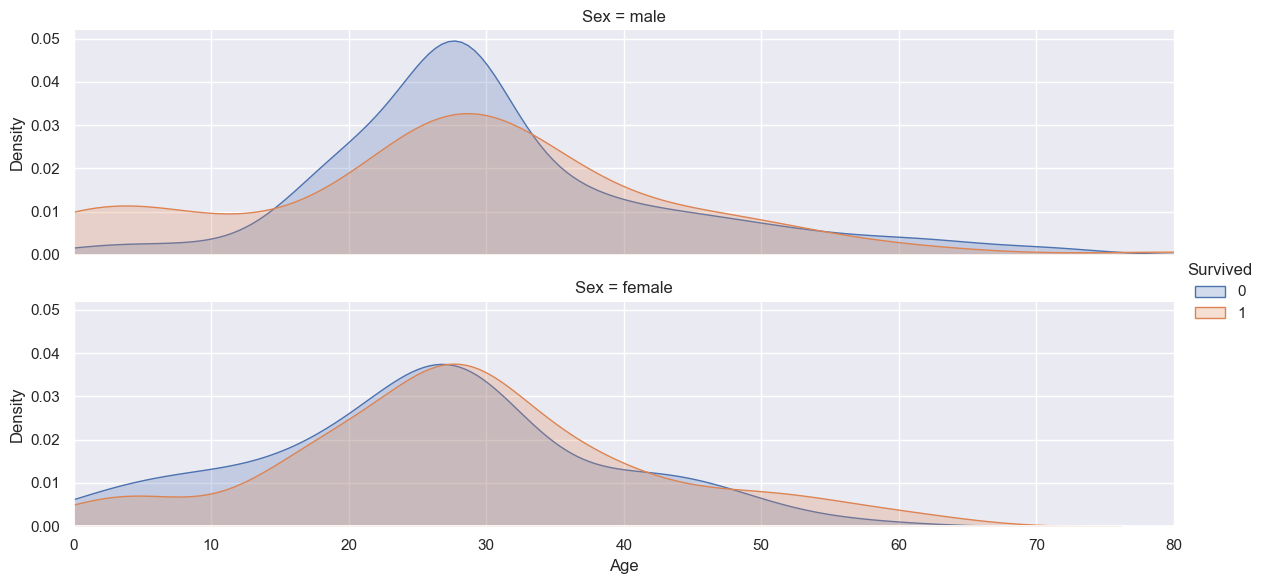

In [19]:
age_sex_survived_plt = sns.FacetGrid(train_df , hue='Survived' , aspect=4 , row = 'Sex' )
age_sex_survived_plt.map( sns.kdeplot, 'Age' , shade= True )
age_sex_survived_plt.set( xlim=( 0 , train_df['Age'].max() ) )
age_sex_survived_plt.add_legend()
plt.show()

In [20]:
train_df[(train_df['Survived']==0) & (train_df['Age']>50)].Sex.value_counts()

Sex
male      41
female     1
Name: count, dtype: int64

In [21]:
train_df[(train_df['Survived']==1) & (train_df['Age']>50)].Sex.value_counts()

Sex
female    16
male       6
Name: count, dtype: int64

### Pclass vs. Survived

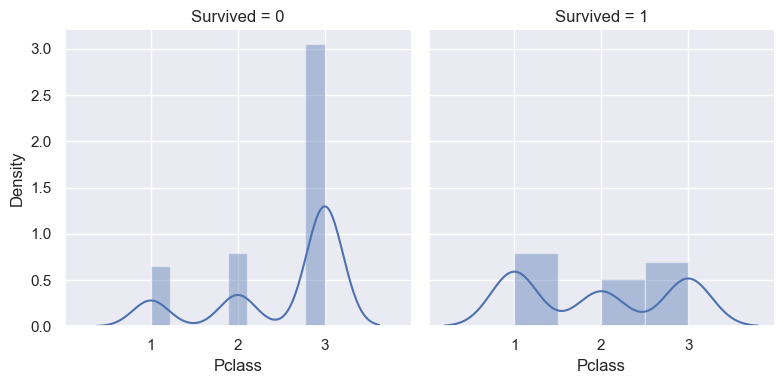

In [22]:
pclass_survived_plt = sns.FacetGrid(train_df, col='Survived', height=4, aspect=1)
pclass_survived_plt.map(sns.distplot, 'Pclass')

plt.show()

### Embarked vs. Survived

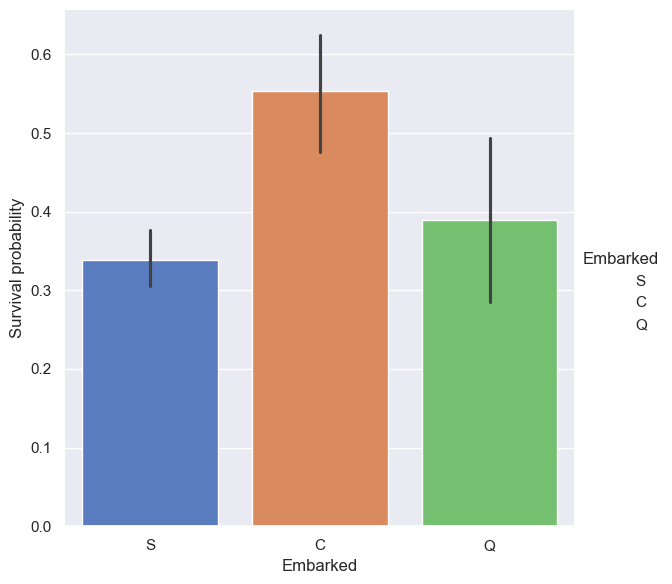

In [23]:
embarked_survived_plt = sns.catplot(data=train_df,
                                       x='Embarked',
                                       y='Survived',
                                       height=6,
                                       kind='bar',
                                       palette='muted')
embarked_survived_plt.despine(left=True)
embarked_survived_plt.set_ylabels('Survival probability')

plt.show()

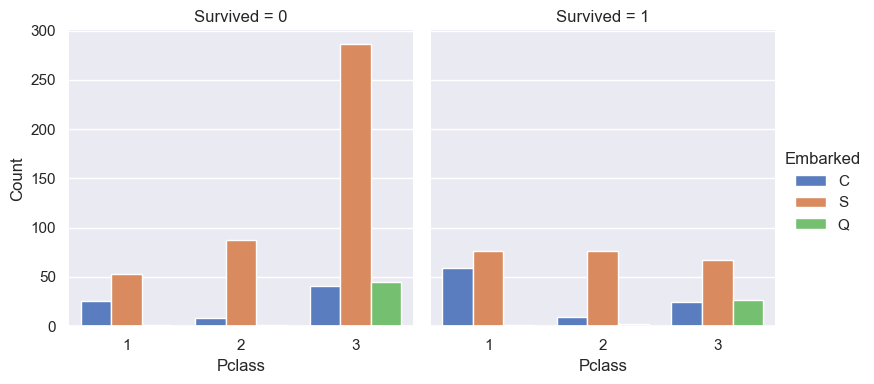

In [24]:
pclass_embarked_survived_plt = sns.catplot(x='Pclass',
                                              col='Survived',
                                              data=train_df,
                                              hue='Embarked',
                                              kind='count',
                                              palette='muted',
                                              height=4,
                                              aspect=1)
pclass_embarked_survived_plt.despine(left=True)
pclass_embarked_survived_plt.set_ylabels('Count')

plt.show()

## Build preprocessing pipeline


In [25]:
# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [26]:
num_attribs = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Pclass', 'Sex', 'Embarked']

### Build pipeline for numeric variables

In [27]:
num_pipeline = Pipeline([
    ('select_numeric', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='median'))
])

In [28]:
num_pipeline.fit_transform(train_df)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

### Build pipeline for categorical variables

In [29]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [30]:
cat_pipeline = Pipeline([
    ('select_numeric', DataFrameSelector(cat_attribs)),
    ('imputer', MostFrequentImputer()),
    ('cat_encoder', OneHotEncoder(sparse=False)) # return an array
])

In [31]:
cat_pipeline.fit_transform(train_df)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

### Join 2 pipelines into a single pipeline

In [32]:
full_pipeline = FeatureUnion(transformer_list=[('num_pipeline', num_pipeline),
                                               ('cat_pipeline', cat_pipeline)]
                            )

In [33]:
X_train = full_pipeline.fit_transform(train_df)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [34]:
y_train = train_df['Survived']

In [35]:
X_test = full_pipeline.fit_transform(test_df)
X_test

array([[34.5,  0. ,  0. , ...,  0. ,  1. ,  0. ],
       [47. ,  1. ,  0. , ...,  0. ,  0. ,  1. ],
       [62. ,  0. ,  0. , ...,  0. ,  1. ,  0. ],
       ...,
       [38.5,  0. ,  0. , ...,  0. ,  0. ,  1. ],
       [27. ,  0. ,  0. , ...,  0. ,  0. ,  1. ],
       [27. ,  1. ,  1. , ...,  1. ,  0. ,  0. ]])

## Train a classifier

### SVM (Support-vector machine)

In [36]:
svr_params = {'kernel': ['rbf'],
              'gamma': [0.001, 0.01, 0.1, 1],
              'C': [1, 10, 50, 100, 200, 300, 1000]}
svr_gridsearch = GridSearchCV(SVC(random_state=42),
                              svr_params,
                              cv=StratifiedKFold(n_splits=10),
                              scoring='accuracy',
                              n_jobs=-1)
svr_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [1, 10, 50, 100, 200, 300, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['rbf']},
             scoring='accuracy')

In [37]:
y_pred_svr = svr_gridsearch.best_estimator_.predict(X_train)
accuracy_score(y_train, y_pred_svr)

0.8327721661054994

### Gaussian Naive Bayes

In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer


In [48]:
pipeline_GNB = make_pipeline(QuantileTransformer(output_distribution='normal'), GaussianNB())
pipeline_GNB.fit(X_train, y_train)

Pipeline(steps=[('quantiletransformer',
                 QuantileTransformer(output_distribution='normal')),
                ('gaussiannb', GaussianNB())])

In [49]:
y_pred_GNB = pipeline_GNB.predict(X_train)

accuracy_score(y_train, y_pred_GNB)

0.7732884399551067

### KNN

In [50]:
knn = KNeighborsClassifier(n_neighbors=3)


# fit the model to the training set
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [51]:
y_pred_knn = knn.predict(X_train)

accuracy_score(y_train, y_pred_knn)

0.8383838383838383

### Decision Trees

In [53]:
decisionTree_params = {'max_features': [1, 3, 10],
                       'min_samples_split': [2, 3, 10],
                       'min_samples_leaf': [1, 3, 10]}
decisionTree_gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=42),
                                       decisionTree_params,
                                       cv=StratifiedKFold(n_splits=10),
                                       scoring='accuracy',
                                       n_jobs=-1)
decisionTree_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_features': [1, 3, 10],
                         'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 3, 10]},
             scoring='accuracy')

In [54]:
y_pred_decisionTree = decisionTree_gridsearch.best_estimator_.predict(X_train)
accuracy_score(y_train, y_pred_decisionTree)

0.8933782267115601

### Random Forest

In [55]:
rdmFrst_params = {'max_depth': [None],
                  'max_features': [1, 3, 10],
                  'min_samples_split': [2, 3, 10],
                  'min_samples_leaf': [1, 3, 10],
                  'bootstrap': [False],
                  'n_estimators':[100,300],
                  'criterion': ['gini']}
rdmFrst_gridsearch = GridSearchCV(RandomForestClassifier(random_state=42),
                                  rdmFrst_params,
                                  cv=StratifiedKFold(n_splits=10),
                                  scoring='accuracy',
                                  n_jobs=-1)
rdmFrst_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [None], 'max_features': [1, 3, 10],
                         'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 3, 10],
                         'n_estimators': [100, 300]},
             scoring='accuracy')

In [56]:
y_pred_rdmFrst = rdmFrst_gridsearch.best_estimator_.predict(X_train)
accuracy_score(y_train, y_pred_rdmFrst)

0.9034792368125701

### Logistic Regression

In [57]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [58]:
y_pred_logReg = log_reg.predict(X_train)
accuracy_score(y_train, y_pred_logReg)

0.8058361391694725

### AdaBoost

In [59]:
ada_params = {'base_estimator__criterion': ['gini', 'entropy'],
              'base_estimator__splitter': ['best', 'random'],
              'algorithm': ['SAMME', 'SAMME.R'],
              'n_estimators': [1, 2],
              'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

ada_gridsearch = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(random_state=42)),
                              param_grid = ada_params,
                              cv=StratifiedKFold(n_splits=10),
                              scoring='accuracy',
                              n_jobs= -1)

ada_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42)),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'base_estimator__criterion': ['gini', 'entropy'],
                         'base_estimator__splitter': ['best', 'random'],
                         'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,
                                           1.5],
                         'n_estimators': [1, 2]},
             scoring='accuracy')

In [60]:
ada_gridsearch.best_score_

0.804769038701623

In [61]:
y_pred_ada = ada_gridsearch.best_estimator_.predict(X_train)
accuracy_score(y_train, y_pred_ada)

0.9797979797979798

### Extra Trees

In [62]:
extraTree_params = {'max_depth': [None],
                    'max_features': [1, 3, 10],
                    'min_samples_split': [2, 3, 10],
                    'min_samples_leaf': [1, 3, 10],
                    'bootstrap': [False],
                    'n_estimators': [100, 300],
                    'criterion': ['gini']}
extraTree_gridsearch = GridSearchCV(ExtraTreesClassifier(random_state=42),
                                    extraTree_params,
                                    cv=StratifiedKFold(n_splits=10),
                                    scoring='accuracy',
                                    n_jobs=-1)
extraTree_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=ExtraTreesClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [None], 'max_features': [1, 3, 10],
                         'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 3, 10],
                         'n_estimators': [100, 300]},
             scoring='accuracy')

In [63]:
extraTree_gridsearch.best_score_

0.8373158551810237

In [64]:
y_pred_extraTree = extraTree_gridsearch.best_estimator_.predict(X_train)
accuracy_score(y_train, y_pred_extraTree)

0.8866442199775533

### Gradient Boosting

In [65]:
gbrt_params = {'n_estimators': [100, 200, 300],
               'loss': ['log_loss'],
               'learning_rate': [0.01, 0.05, 0.1],
               'max_depth': [4, 8],
               'min_samples_leaf': [100, 150],
               'max_features': [0.1, 0.3]}
gbrt_gridsearch = GridSearchCV(GradientBoostingClassifier(random_state=42),
                               gbrt_params,
                               cv=StratifiedKFold(n_splits=10),
                               scoring='accuracy',
                               n_jobs=-1)
gbrt_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'loss': ['log_loss'], 'max_depth': [4, 8],
                         'max_features': [0.1, 0.3],
                         'min_samples_leaf': [100, 150],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [66]:
gbrt_gridsearch.best_score_

0.817103620474407

In [67]:
y_pred_gbrt = gbrt_gridsearch.best_estimator_.predict(X_train)
accuracy_score(y_train, y_pred_gbrt)

0.8294051627384961

### Voting classifier

In [68]:
voting_hard_clf = VotingClassifier(
    estimators=[('svm', svr_gridsearch.best_estimator_),
                ('dt', decisionTree_gridsearch.best_estimator_),
                ('rf', rdmFrst_gridsearch.best_estimator_),
                ('lr', log_reg),
                ('ada', ada_gridsearch.best_estimator_),
                ('extraTree', extraTree_gridsearch.best_estimator_),
                ('gbrt', gbrt_gridsearch.best_estimator_)],
    voting='hard'
)

voting_hard_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('svm', SVC(C=100, gamma=0.001, random_state=42)),
                             ('dt',
                              DecisionTreeClassifier(max_features=10,
                                                     min_samples_leaf=3,
                                                     min_samples_split=10,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     max_features=3,
                                                     min_samples_leaf=3,
                                                     random_state=42)),
                             ('lr', LogisticRegression()),
                             ('ada',
                              AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                  random_state=42,
                                                                                  splitter='random'),
                                                 learning_rate=0.0001,
                                                 n_estimators=2)),
                             ('extraTree',
                              ExtraTreesClassifier(max_features=10,
                                                   min_samples_leaf=3,
                                                   n_estimators=300,
                                                   random_state=42)),
                             ('gbrt',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=4,
                                                         max_features=0.3,
                                                         min_samples_leaf=150,
                                                         n_estimators=300,
                                                         random_state=42))])

In [69]:
y_pred_voting_hard = voting_hard_clf.predict(X_train)
accuracy_score(y_train, y_pred_voting_hard)

0.898989898989899

In [70]:
voting_hard_clf_90 = VotingClassifier(
    estimators=[('svm', svr_gridsearch.best_estimator_),
                ('rf', rdmFrst_gridsearch.best_estimator_),
                ('ada', ada_gridsearch.best_estimator_),
                ('extraTree', extraTree_gridsearch.best_estimator_),
                ('gbrt', gbrt_gridsearch.best_estimator_)],
    voting='hard'
)

voting_hard_clf_90.fit(X_train, y_train)

VotingClassifier(estimators=[('svm', SVC(C=100, gamma=0.001, random_state=42)),
                             ('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     max_features=3,
                                                     min_samples_leaf=3,
                                                     random_state=42)),
                             ('ada',
                              AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                  random_state=42,
                                                                                  splitter='random'),
                                                 learning_rate=0.0001,
                                                 n_estimators=2)),
                             ('extraTree',
                              ExtraTreesClassifier(max_features=10,
                                                   min_samples_leaf=3,
                                                   n_estimators=300,
                                                   random_state=42)),
                             ('gbrt',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=4,
                                                         max_features=0.3,
                                                         min_samples_leaf=150,
                                                         n_estimators=300,
                                                         random_state=42))])

In [71]:
y_pred_voting_hard_90 = voting_hard_clf_90.predict(X_train)
accuracy_score(y_train, y_pred_voting_hard_90)

0.9034792368125701

In [72]:
svr_gridsearch.best_estimator_.probability = True
voting_soft_clf = VotingClassifier(
    estimators=[('svm', svr_gridsearch.best_estimator_),
                ('dt', decisionTree_gridsearch.best_estimator_),
                ('rf', rdmFrst_gridsearch.best_estimator_),
                ('lr', log_reg),
                ('ada', ada_gridsearch.best_estimator_),
                ('extraTree', extraTree_gridsearch.best_estimator_),
                ('gbrt', gbrt_gridsearch.best_estimator_)],
    voting='soft'
)

voting_soft_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('svm',
                              SVC(C=100, gamma=0.001, probability=True,
                                  random_state=42)),
                             ('dt',
                              DecisionTreeClassifier(max_features=10,
                                                     min_samples_leaf=3,
                                                     min_samples_split=10,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     max_features=3,
                                                     min_samples_leaf=3,
                                                     random_state=42)),
                             ('lr', LogisticRegression()),
                             ('ada',
                              AdaBoostClassifier(est...riterion='entropy',
                                                                                  random_state=42,
                                                                                  splitter='random'),
                                                 learning_rate=0.0001,
                                                 n_estimators=2)),
                             ('extraTree',
                              ExtraTreesClassifier(max_features=10,
                                                   min_samples_leaf=3,
                                                   n_estimators=300,
                                                   random_state=42)),
                             ('gbrt',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=4,
                                                         max_features=0.3,
                                                         min_samples_leaf=150,
                                                         n_estimators=300,
                                                         random_state=42))],
                 voting='soft')

In [73]:
y_pred_voting_soft = voting_soft_clf.predict(X_train)
accuracy_score(y_train, y_pred_voting_soft)

0.9169472502805837

### Compare different models' accuracy score

In [75]:
accuracy_score_df = pd.DataFrame({'Models': ['SVM',
                                             'Gaussian Naive Bayes',
                                             'KNN',
                                             'Decision Trees',
                                             'Random Forest',
                                             'Logistic Regression',
                                             'AdaBoost',
                                             'Extra Trees',
                                             'Gradient Boosting',
                                             'Hard voting',
                                             'Hard voting gt 90pct',
                                             'Soft voting'],
                                  'Accuracy score': [accuracy_score(y_train, y_pred_svr),
                                                     accuracy_score(y_train, y_pred_GNB),
                                                     accuracy_score(y_train, y_pred_knn),
                                                     accuracy_score(y_train, y_pred_decisionTree),
                                                     accuracy_score(y_train, y_pred_rdmFrst),
                                                     accuracy_score(y_train, y_pred_logReg),
                                                     accuracy_score(y_train, y_pred_ada),
                                                     accuracy_score(y_train, y_pred_extraTree),
                                                     accuracy_score(y_train, y_pred_gbrt),
                                                     accuracy_score(y_train, y_pred_voting_hard),
                                                     accuracy_score(y_train, y_pred_voting_hard_90),
                                                     accuracy_score(y_train, y_pred_voting_soft)]},
                                 columns=['Models', 'Accuracy score'])
accuracy_score_df.sort_values('Accuracy score', inplace=True, ascending=False)
accuracy_score_df.reset_index(inplace=True, drop=True)

In [76]:
accuracy_score_df

,Models,Accuracy score
0,AdaBoost,0.979798
1,Soft voting,0.916947
2,Random Forest,0.903479
3,Hard voting gt 90pct,0.903479
4,Hard voting,0.898990
5,Decision Trees,0.893378
6,Extra Trees,0.886644
7,KNN,0.838384
8,SVM,0.832772
9,Gradient Boosting,0.829405


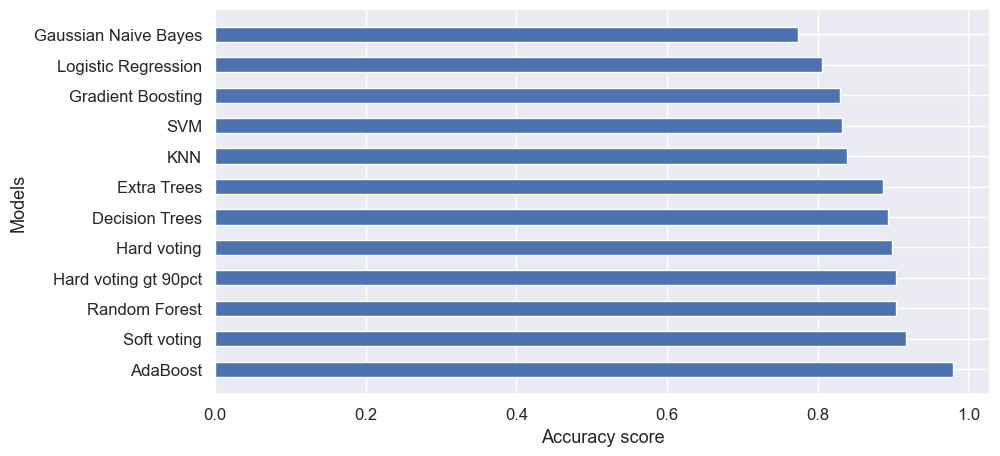

In [77]:
plt.figure(figsize=(10, 5))
plt.barh(np.arange(len(accuracy_score_df['Models'])),
         accuracy_score_df['Accuracy score'],
         align='center',
         height=0.5)

plt.yticks(np.arange(len(accuracy_score_df['Models'])), accuracy_score_df['Models'])
plt.tick_params(labelsize=12)
plt.xlabel('Accuracy score', fontdict={'fontsize': 13})
plt.ylabel('Models', fontdict={'fontsize': 13})

plt.show()

### Compare different models' best_score_

In [78]:
best_score_df = pd.DataFrame({'Models': ['SVM',
                                         'Decision Trees',
                                         'Random Forest',
                                         'AdaBoost',
                                         'Extra Trees',
                                         'Gradient Boosting'],
                              'best_score_': [svr_gridsearch.best_score_,
                                              decisionTree_gridsearch.best_score_,
                                              rdmFrst_gridsearch.best_score_,
                                              ada_gridsearch.best_score_,
                                              extraTree_gridsearch.best_score_,
                                              gbrt_gridsearch.best_score_]},
                             columns=['Models', 'best_score_'])
best_score_df.sort_values('best_score_', inplace=True, ascending=False)
best_score_df.reset_index(inplace=True, drop=True)

In [79]:
best_score_df

,Models,best_score_
0,Extra Trees,0.837316
1,Random Forest,0.832846
2,Decision Trees,0.818227
3,Gradient Boosting,0.817104
4,SVM,0.806991
5,AdaBoost,0.804769


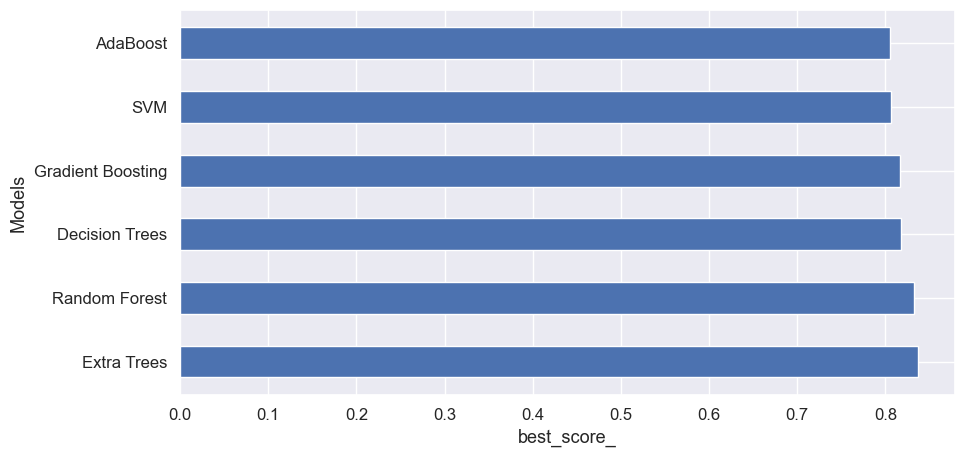

In [80]:
plt.figure(figsize=(10, 5))
plt.barh(np.arange(len(best_score_df['Models'])), best_score_df['best_score_'], align='center', height=0.5)

plt.yticks(np.arange(len(best_score_df['Models'])), best_score_df['Models'])
plt.tick_params(labelsize=12)
plt.xlabel('best_score_', fontdict={'fontsize': 13})
plt.ylabel('Models', fontdict={'fontsize': 13})

plt.show()

## Prediction with test data

In [81]:
y_test = voting_soft_clf.predict(X_test)

In [82]:
passengerID_test = test_df['PassengerId']
output_df = pd.DataFrame({'PassengerId':passengerID_test,
                          'Survived': y_test},
                         columns=['PassengerId', 'Survived'])

In [83]:
output_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [84]:
len(output_df)

418

In [85]:
output_df.to_csv('titanic_predict_survivals.csv', index=False)